In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualizations
from sklearn.utils import shuffle # Used for shuffling the data
import os # Deal with the file system
import shutil # Helps with copying to working directory
import cv2 # Handle images
from tqdm.notebook import tqdm, trange # loader bar

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

INPUT_DIR = "/kaggle/input/histopathologic-cancer-detection"
RANDOM_STATE = 1 # Set to None if reproducibility is not needed
DEBUG_SAMPLE_FRAC = 1 # Reduce the amount of data used so that debugging the notebook is faster

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Brief Introduction to the Problem and the Data
With this competition we develop algorithms that can identify metastatic cancer in small image patches. This technology has the potential to improve the early detection and diagnosis of cancer, which could lead to better outcomes for patients.  We see a few terms that are a little difficult to understand, so lets make them more approachable for non-medical professionals.

## The Terms
**Histopathology** is the study of diseased tissue using a microscope. It is a branch of pathology that deals with the microscopic examination of tissues and cells to diagnose disease. Histopathology is used to diagnose a wide range of diseases, including cancer, infections, and autoimmune diseases.

A pathologist will typically take a biopsy of tissue from a patient and prepare it for microscopic examination. The tissue is then stained with various dyes to make the different structures of the tissue more visible. The pathologist will then examine the tissue under a microscope and look for signs of disease.

**Metastatic cancer** is a type of cancer that has spread from its original location to other parts of the body. This happens when cancer cells break away from the tumor and travel through the bloodstream or lymphatic system to other parts of the body. When cancer cells reach a new part of the body, they can start to grow and form new tumors.


## The Problem
The problem is to identify metastatic cancer in small image patches taken from larger digital pathology scans. Given whole slide images from a modified (no-duplicates) version of the PCam dataset, the goal is to identify if the center region of the patch contains at least one pixel of tumor tissue.

Since we are seeking to classify each image as indicating cancer or not, this is a binary classifiaction problem.

## The Data
The data is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. The dataset contains a large number of small pathology images, each with a ground truth label indicating whether or not it contains metastatic cancer. The goal is to train a model to predict the labels for the images in the test set.

There are about 220K images to train with and about 57K images to test on.



# Exploratory Data Analysis
Lets conduct some exploratory data analysis to understand the data a little better.

## The Labels
In our input data, there is a set of labels for the training data.  First, the shape of this dataset:

In [2]:
train_labels = pd.read_csv(f"{INPUT_DIR}/train_labels.csv")
print(f"Shape of Dataset: {train_labels.shape}")

Shape of Dataset: (220025, 2)


Next, the data is described

In [3]:
train_labels.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


To build a sense of what the labels look like, lets take a look at the first few rows

In [4]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Now lets see how those training rows are distributed over positive and negative labels

In [5]:
pos = train_labels.loc[train_labels['label'] == 1].count()[0]
neg = train_labels.loc[train_labels['label'] == 0].count()[0]
pos_pct = round(100*pos/(pos+neg))
neg_pct = round(100*neg/(pos+neg))
print(f"Training data has {pos} positive labels and {neg} negative labels")
print(f"This means the training data hs {pos_pct}% positive labels and {neg_pct}% negative labels")

Training data has 89117 positive labels and 130908 negative labels
This means the training data hs 41% positive labels and 59% negative labels


Lets ensure that we only have the expected number unique entries in each column (every one is unique in the id, and only 1 unique labels)

In [6]:
train_labels.nunique()

id       220025
label         2
dtype: int64

Great!  Now the data is checked for any missing data or any values that should not be there. Any unknowns are converted to NA values and depending on how many NAs there are, those cells or features are dropped or imputed. Here is a tally of how many null values are in the data.

In [7]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
row_str = "{:<22}{:<15}{:<15}"
print(row_str.format("Column Name", "Real Nulls", "Null-like"))
print("----------------------------------------------")
for c in train_labels.columns:
    string_null = np.array([x in a[2:] for x in train_labels[c]])
    print(row_str.format(c, str(train_labels[c].isnull().sum()), str(string_null.sum())))

Column Name           Real Nulls     Null-like      
----------------------------------------------
id                    0              0              
label                 0              0              


## The Images
The data also has several images in the test and train directories.  Below is how many in each.

In [8]:
num_train_files = len(os.listdir(f"{INPUT_DIR}/train"))
num_test_files = len(os.listdir(f"{INPUT_DIR}/test"))
print(f"There are {num_train_files} training images and {num_test_files} test images")

There are 220025 training images and 57458 test images


Next a few of the images are previewed to build a sense of what the full slide images look like.

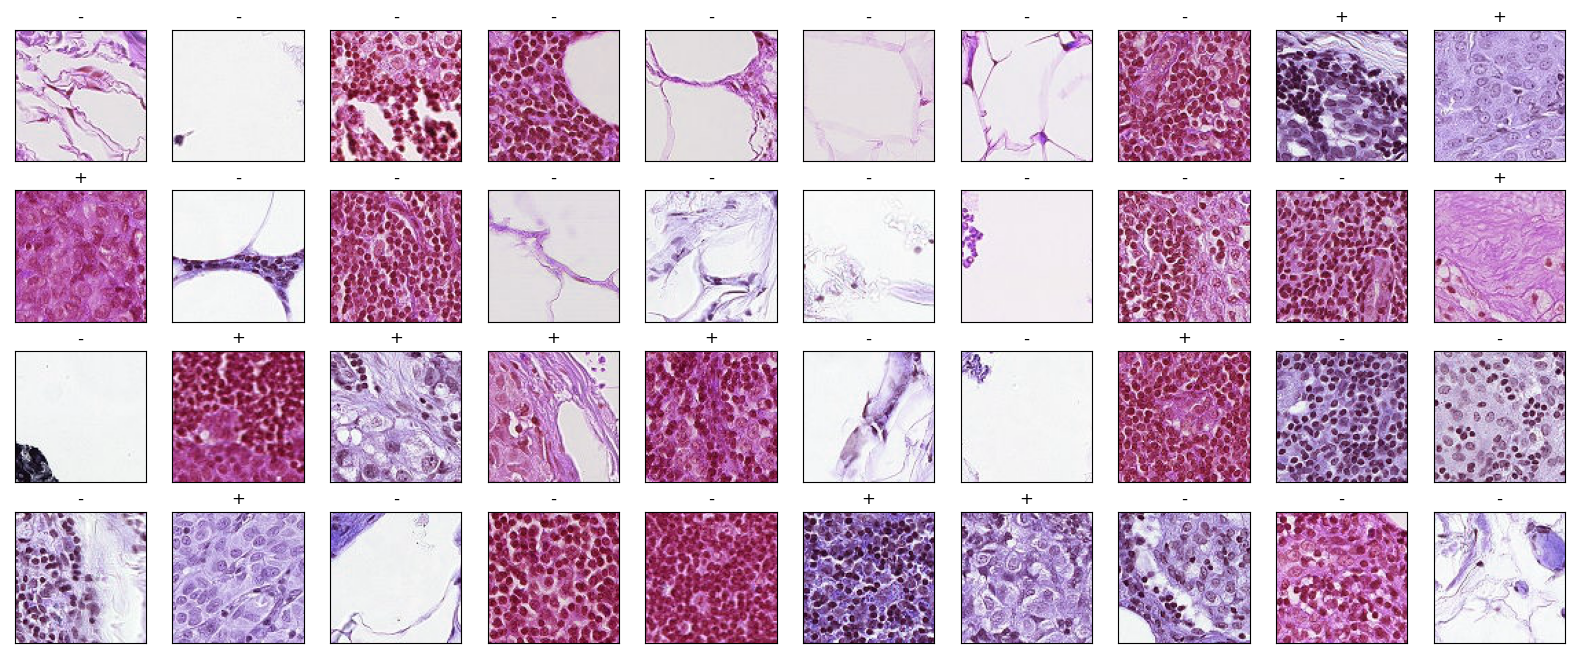

In [9]:
fig = plt.figure(figsize=(20, 8))

training_imgs = os.listdir(f"{INPUT_DIR}/train")

# Select some random images to show
num_images = 40
num_rows = 4
for i, img_name in enumerate(np.random.choice(training_imgs, num_images)):
    ax = fig.add_subplot(num_rows, num_images//num_rows, i+1, xticks=[], yticks=[])
    img = cv2.imread(f"{INPUT_DIR}/train/{img_name}")
    plt.imshow(img)
    
    lbl = train_labels.loc[train_labels['id'] == img_name.split('.')[0]].values[0][1]
    lbl = "+" if lbl==1 else "-"
    ax.set_title(f"{lbl}")

## EDA Conclusion
Based on this EDA, the data looks to be a set of small images, classified with a binary label (positive/1 or negative/0).  The goal is to classify further images in this binary manner as well. 

Since this is an image classification goal, the plan looks to be building and training a Convolutional Neural Network that will be able to classify a full slide image as indicating metastisized cancer cells in the center.

# Model Architecture
With a stronger sense of the training data and the goal, the next discussion is which model architecture to use and train for best results.  Selecting the right model architecture is important because it will use the right amount of resources for the task, will not overfit the data, and will give accurate classification results.

## Options for Architecture
If our plan is to use a Convolutional Neural Network to classify slide images, there are still options within this plan.  The loss function must be selected, with possible choices including mean absolute error (mae), mean squared error (mse), and Huber loss for regression loss calculations.  This problem is a binary/classification problem so there are the options of Binary Cross Entropy or Poisson. 

Additionally the activation function for the linear units must be selected.  Choices here include Sigmoid, TanH, and ReLU.  Since ReLU has shown great promise with training Neural Network (NN) models and since it also can increase the speed of the model learning, this will be the activation function selected here.

Additionally, it is possible to select strategies to optimize the hyperparameters of an NN model and one of the most popular and effective strategies is Stochastic Gradient Descent.  This will be the selected strategy for optimizing the NN to reduce loss.

## Tools of Choice
Keras and Tensorflow offer a framework by which much of the data, modelling, tuning, can be described and implemented.


## Sampling of the Data
First, we separate the validation set from the training data by taking a random subsample from the training data.  A section of the training data will be reserved and will later be used to validate the model.

This offers the ability to test the model training process on slightly different training data each run, as well as the ability to validate the model on data different from what was used to train the model.

In [10]:
# Select a sample of positive and negative labelled images to work with so we can debug with smaller pools of data

pos_labels = train_labels[train_labels['label'] == 1].sample(frac=DEBUG_SAMPLE_FRAC, random_state=RANDOM_STATE)
neg_labels = train_labels[train_labels['label'] == 0].sample(frac=DEBUG_SAMPLE_FRAC, random_state=RANDOM_STATE)

selected_data = shuffle(pd.concat([pos_labels, neg_labels], axis=0).reset_index(drop=True))


In [11]:
# Prepare selected_data for consumption by flow_from_dataframe
# Convert the label to string
selected_data['label'] = selected_data['label'].astype(str)
# Convert the id to actual filenames
selected_data['id'] = selected_data['id'] + ".tif"

In [12]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
RANDOM_STATE = 1
IMG_SIZE = (96, 96)

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=VALIDATION_SPLIT
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=selected_data,
    directory=f"{INPUT_DIR}/train",
    x_col="id",
    y_col="label",
    subset="training",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="binary"
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=selected_data,
    directory=f"{INPUT_DIR}/train",
    x_col="id",
    y_col="label",
    subset="validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Results and Analysis
Next, the data model is set up and fit to the training data, and the resulting accuracy is noted.  

However, before beginning training, an early stopper and a learning rate modifiers are implemented.

In [13]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [14]:
KERNEL_SIZE = (3, 3)
ACTIVATION = "relu"
POOL_SIZE = (2, 2)

model = Sequential()

# First convolutional block of layers
FILTERS = 3
model.add(Conv2D(input_shape=(96,96,3), filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(MaxPool2D(POOL_SIZE))
model.add(Dropout(0.3)) # Helps prevent overfitting by zeroing out this ratio of input units 

model.add(Flatten())
model.add(Dense(256, activation=ACTIVATION))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 3)         84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 3)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 3)         0         
                                                                 
 flatten (Flatten)           (None, 6627)              0         
                                                                 
 dense (Dense)               (None, 256)               1696768   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

With the model defined, the next step is to compile the model and specify the strategy to optimize hyper parameters, calculate loss, and which metrics are important.

Adam is a good general purpose optimizer.  Since this is a binary classification problem, binary_crossentropy is selected as the loss function.  Finally, the model will be aimed to optimize for accuracy.

In [15]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

TRAIN_STEPS = train_gen.n // BATCH_SIZE
VALID_STEPS = valid_gen.n // BATCH_SIZE
EPOCHS = 4

model.fit(
    train_gen,
    steps_per_epoch=TRAIN_STEPS,
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=VALID_STEPS,
    callbacks=[reducel, earlystopper],
    use_multiprocessing=True
)

Epoch 1/4
5500/5500 [==============================] - 1665s 302ms/step - loss: 2.1522 - accuracy: 0.7141 - val_loss: 0.5107 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 2/4
5500/5500 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7605
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5500/5500 [==============================] - 888s 161ms/step - loss: 0.5270 - accuracy: 0.7605 - val_loss: 0.5226 - val_accuracy: 0.7739 - lr: 0.0010
Epoch 3/4
5500/5500 [==============================] - 673s 122ms/step - loss: 0.4817 - accuracy: 0.7847 - val_loss: 0.4766 - val_accuracy: 0.7878 - lr: 1.0000e-04
Epoch 4/4
5500/5500 [==============================] - 655s 119ms/step - loss: 0.4752 - accuracy: 0.7877 - val_loss: 0.4744 - val_accuracy: 0.7885 - lr: 1.0000e-04


This iteration of a CNN predicted in the validation set with good accuracy

## Improving the model
The model may be improved by a few strategies.  The first is to introduce more blocks of convolutional layers. A further optimization that is seen in CNNs is to use deeper filters in later layers of the CNN.  The following implementation of model includes both updates.

In [16]:
model = Sequential()

# First convolutional block of layers
FILTERS = 32 # Power of 2 depth of filters
model.add(Conv2D(input_shape=(96,96,3), filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(MaxPool2D(POOL_SIZE))
model.add(Dropout(0.3)) # Helps prevent overfitting by zeroing out this ratio of input units 

# Second convolutional block
FILTERS=64
model.add(Conv2D(input_shape=(96,96,3), filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(MaxPool2D(POOL_SIZE))
model.add(Dropout(0.3)) # Helps prevent overfitting by zeroing out this ratio of input units 

# Third convolutional block
FILTERS=128
model.add(Conv2D(input_shape=(96,96,3), filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(MaxPool2D(POOL_SIZE))
model.add(Dropout(0.3)) # Helps prevent overfitting by zeroing out this ratio of input units 

model.add(Flatten())
model.add(Dense(256, activation=ACTIVATION))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 64)       

With this new model, the model is fit once more.

In [17]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_gen,
    steps_per_epoch=TRAIN_STEPS,
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=VALID_STEPS,
    callbacks=[reducel, earlystopper],
    use_multiprocessing=True
)

Epoch 1/4
5500/5500 [==============================] - 2006s 364ms/step - loss: 0.8676 - accuracy: 0.7790 - val_loss: 0.4948 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 2/4
5500/5500 [==============================] - 2074s 377ms/step - loss: 0.4323 - accuracy: 0.8087 - val_loss: 0.4453 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 3/4
5500/5500 [==============================] - 2050s 373ms/step - loss: 0.3954 - accuracy: 0.8285 - val_loss: 0.3633 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 4/4
5500/5500 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8402
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5500/5500 [==============================] - 2069s 376ms/step - loss: 0.3711 - accuracy: 0.8402 - val_loss: 0.3857 - val_accuracy: 0.8341 - lr: 0.0010


Indeed deeper filters yields better image classification accuracy. 

While more hyperparamater tuning may be done, the acheived prediction accuracy of the most recent model is satisfactory.
Using this model, the submission may be built.

### Plot ROC Curve
The ROC Curve is how the submission will be assessed.  Here is what the ROC Curve looks like for the most recently fit model. Predictions are run and evaluated using the validation set.

In [18]:
y_pred = model.predict(valid_gen)
y_pred = y_pred.round().squeeze()

fpr, tpr, _ = roc_curve(valid_gen.classes, y_pred)
auc = auc(fpr, tpr)
auc

1376/1376 [==============================] - 142s 103ms/step


0.8209576688595607

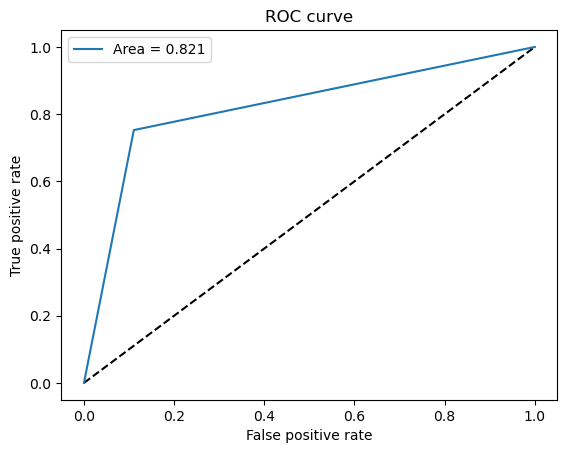

In [19]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Predicting for Submission
In order to predict from the test set of images, first the test set of images is encapsulated by code to fetch the data from those images.


In [20]:
test_df = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv")

test_df = test_df.sample(frac=DEBUG_SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)

# Prepare test_df for consumption by flow_from_dataframe
# Convert the label to string
test_df['label'] = test_df['label'].astype(str)
# Convert the id to actual filenames
test_df['id'] = test_df['id'] + ".tif"

test_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)

test_gen = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=f"{INPUT_DIR}/test",
    x_col="id",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode=None,
)


Found 57458 validated image filenames.


Next, the model is used to build predictions from the set of images in the test set.

In [21]:
pred = model.predict(test_gen)
pred = pred.round().squeeze()
print(pred[:5])


1796/1796 [==============================] - 505s 281ms/step
[0. 1. 0. 0. 1.]


### Saving the Submission
Finally, save the predictions to a dataframe, and ensure the columns offer values in the expected format.

In [22]:
submissions_df = pd.DataFrame({'id': test_gen.filenames,
                            'label':pred})

# Convert the submissions dataframe columns to what we expect
submissions_df['id'] = submissions_df['id'].str.replace('.tif', '', regex=False)
submissions_df['label'] = submissions_df['label'].astype('int8')
submissions_df.head()

,id,label
0,74223f534cb92a321396fd7cca271cb953cc0d27,0
1,ac0e6a32cc93bb7aa9db144bcebd9abf3fdae9b0,1
2,ecc12586b3c35992d9ed945f0e604039bc730898,0
3,414dbd1570cb9468a059c3e5b6c0622c4c4e91a5,0
4,e99bcfaf715ef96fd95c323e33d0bbdc84ab4f65,1


Save those submissions to an output csv

In [23]:
submissions_df.to_csv("/kaggle/working/submission.csv", index=False, header=True)
print("Exported to CSV")

Exported to CSV


# Conclusion
In this study, we explored the use of convolutional neural networks (CNNs) for histopathologic cancer detection prediction. We found that adding convolutional layers to the model improved the accuracy of the model, but also increased the training time. We also found that increasing the filter sizes of the later convolutional layers improved the accuracy of the model. Finally, we found that keeping larger filters but removing some of the convolutional layers resulted in a model with similar accuracy but shorter training time.

Overall, our findings suggest that CNNs are a promising tool for histopathologic cancer detection prediction. However, further research is needed to optimize the design of CNNs for this task.  Future improvements might be to further clean the training set, perhaps by removing images that are too dark or bright.  We could also increase the number of convolutional layers, as some popular architectures have tens or hundreds of such layers.  Such choices, of course, depend on the computing resources available to us if not the time we allow the model to train on the data using the available resources.